In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties

sns.set_style('darkgrid')
titleFont = FontProperties(weight='bold', size=20)
axisFont = FontProperties(weight='bold', size=14) 

from trading.exchange import BackTestExchange
from trading.dataManager import CurrencyDataManager
from trading.money.contract import ContractPair, Contract
from trading.statistics import Statistics
from trading.money.transaction import BuyTransaction, SellTransaction
from calculator.talibWrapper import calculateTalib

C:\Anaconda3\lib\site-packages\pandas\core\computation\__init__.py:18: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [3]:
from calculator.talibWrapper import talibFunctionInfo
talibFunctionInfo('BBANDS')

'BBANDS([input_arrays], [timeperiod=5], [nbdevup=2], [nbdevdn=2], [matype=0])\n\nBollinger Bands (Overlap Studies)\n\nInputs:\n    price: (any ndarray)\nParameters:\n    timeperiod: 5\n    nbdevup: 2\n    nbdevdn: 2\n    matype: 0 (Simple Moving Average)\nOutputs:\n    upperband\n    middleband\n    lowerband'

# Load Data

In [4]:
usdtBtc = pd.read_csv('data/USDT-BTC_15min_2016-01-01_2017-11-28.tsv', sep='\t')
usdtBtcManager = CurrencyDataManager(usdtBtc)
wallet = {'usdt': 1000}
contractPair = ContractPair('usdt', 'btc')

# Bollinger Bands

Bollinger Bands consist of a moving average and two standard deviations,
one above the moving average and one below. The important thing
to know about Bollinger Bands is that they contain up to 95% of the
closing prices, depending on the settings.

- A buy signal is generated when prices move below the lower Bollinger Band.
- A sell signal is generated when prices move above the upper Bollinger Band.

Source: Markus Heitkoetter: The Complet Guide to Day Trading

In [14]:
data = {
            'close': usdtBtc.head(10)['close'].values,
        }
        
upper, middle, lower = calculateTalib('BBANDS', data, {'timeperiod': 5})

In [21]:
from copy import deepcopy

class BollingerBandsStrategy:
    def __init__(self, exchange, dataManager, timePeriod, contractPair, opened=False):
        self.exchange = exchange
        self.walletStart = deepcopy(self.exchange.wallet)
        self.dataManager = dataManager
        self.timePeriod = timePeriod
        self.contractPair = contractPair
        self.opened = opened

    def calculateBBands(self, history, col, timePeriod):
        upper, middle, lower = calculateTalib('BBANDS', {col: history[col].values}, {'timeperiod': timePeriod})
        return upper[-1], middle[-1], lower[-1]
    
    
    def isRisky(self, priceBought, actualPrice):
        return float(actualPrice) / priceBought < 0.95
    
    
    def trade(self):
        while self.dataManager.hasTick():
            history, price = self.dataManager.tick(self.timePeriod)
            if history.shape[0] < self.timePeriod:
                continue

            upper, middle, lower = self.calculateBBands(history, 'close', self.timePeriod)

            if not self.opened and price < lower:
                amount = (0.1 * self.exchange.balance(self.contractPair.priceContract)) / price  
                self.exchange.buy(self.contractPair, amount, price)
                priceBought = price
                self.opened = True
            elif self.opened and self.isRisky(priceBought, price):
                self.opened = False
                amount = self.exchange.balance(self.contractPair.tradeContract)
                self.exchange.sell(self.contractPair, amount, price)
            elif self.opened and price > middle:
                self.opened = False
                amount = self.exchange.balance(self.contractPair.tradeContract)
                self.exchange.sell(self.contractPair, amount, price)
                
    def stats(self, contractName):
        return Statistics(contractName, self.walletStart[contractName]).evaluate(self.exchange.transactions)
        

# Learning Slow and Fast Timeperiod

In [22]:
dataManager = deepcopy(usdtBtcManager)
exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0035)
strategy = BollingerBandsStrategy(exchange, dataManager, 50, contractPair)
strategy.trade()
strategy.stats('usdt').report()

,usdt
startAmount,"1,000.0000"
numberOfTrades,756.0000
totalProfit,-73.7437
avgProfit,-0.0975
winPercentage,53.5714
avgWinTrade,1.3185
avgLossTrade,-1.7315
profitFactor,0.8787
maxDrawdown,19.4082


In [21]:
allStats

,contract,startAmount,numberOfTrades,totalProfit,avgProfit,winPercentage,avgWinTrade,avgLossTrade,profitFactor,maxDrawdown,timePeriodFast,timePeriodSlow
0,usdt,"1,000.0000",214.0000,-15.9659,-0.0746,35.5140,5.3831,-2.2849,1.2975,6.4125,96,192
0,usdt,"1,000.0000",149.0000,18.5398,0.1244,36.2416,7.6027,-2.9305,1.4747,3.8383,96,288
0,usdt,"1,000.0000",167.0000,-44.5894,-0.2670,38.3234,6.1445,-3.2162,1.1871,7.2764,192,288


In [22]:
import time

allStats = None
for slow in range(96, 96*30, 96):
    print('fast:', slow, end='')
    for fast in range(96, slow, 96):
        print('\t slow', fast, end='')
        start_time = time.time()
        dataManager = deepcopy(usdtBtcManager)
        exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0035)
        strategy = CrossoverMAStrategy(exchange, dataManager, slow, fast, contractPair)
        strategy.trade()
        stats = strategy.stats('usdt').report().transpose().reset_index().rename(columns={'index': 'contract'})
        stats['timePeriodFast'] = fast
        stats['timePeriodSlow'] = slow
        if allStats is None:
            allStats = stats
        else:
            allStats = allStats.append(stats)
        print("\t %.2f seconds" % (time.time() - start_time))
        print("\t", end='')
    print()

fast: 96
fast: 192	 slow 96	 22.75 seconds
	
fast: 288	 slow 96	 22.66 seconds
		 slow 192	 22.77 seconds
	
fast: 384	 slow 96	 22.77 seconds
		 slow 192	 22.69 seconds
		 slow 288	 22.78 seconds
	
fast: 480	 slow 96	 22.71 seconds
		 slow 192	 22.71 seconds
		 slow 288	 22.65 seconds
		 slow 384	 22.78 seconds
	
fast: 576	 slow 96	 26.24 seconds
		 slow 192	 23.76 seconds
		 slow 288	 22.66 seconds
		 slow 384	 22.66 seconds
		 slow 480	 22.55 seconds
	
fast: 672	 slow 96	 22.71 seconds
		 slow 192	 22.73 seconds
		 slow 288	 22.59 seconds
		 slow 384	 22.60 seconds
		 slow 480	 22.60 seconds
		 slow 576	 22.51 seconds
	
fast: 768	 slow 96	 22.69 seconds
		 slow 192	 22.64 seconds
		 slow 288	 22.66 seconds
		 slow 384	 22.47 seconds
		 slow 480	 22.42 seconds
		 slow 576	 22.51 seconds
		 slow 672	 22.63 seconds
	
fast: 864	 slow 96	 22.68 seconds
		 slow 192	 22.63 seconds
		 slow 288	 22.60 seconds
		 slow 384	 22.59 seconds
		 slow 480	 22.56 seconds
		 slow 576	 22.56 seconds
		 

# Look on transactions

In [ ]:
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates

import time
import datetime as dt

def timestampToDate(timestamp):
    return dt.datetime.fromtimestamp(int(timestamp))

def strTimeToTimestamp(strTime):
    return dt.datetime.strptime(strTime, "%Y-%m-%d %H:%M:%S").timestamp()


def calculateMA(history, col, timePeriod):
        return calculateTalib('MA', {col: history[col].values}, {'timeperiod': timePeriod})


def plotCandles(df, currencyPair):
    DATA = df[['open', 'high', 'low', 'close', 'volume', 'date', 'timestamp']].copy()
    DATA = DATA.reset_index()
    DATA["dateStr"] = DATA["date"]
    DATA["date"]  = DATA["timestamp"].apply(timestampToDate).apply(mdates.date2num)

    plt.figure(figsize=(16, 8))
    ax = plt.gca()
    candlestick_ohlc(ax, DATA.values, width=.6, colorup='#53c156', colordown='#ff1717')

    ax.xaxis_date()
    
    xDates = DATA['dateStr']
    step = int(xDates.shape[0] / 20) + 1
    xDates[[i for i in range(xDates.shape[0]) if i % step != 0]] = ''
    
    plt.xticks(range(DATA.shape[0]), DATA['dateStr'], rotation=45)
    plt.title(currencyPair, fontproperties=titleFont)
    

def plotMA( df, col, timeperiod):
    ma = calculateMA(df, col, timeperiod)
    return plt.plot(ma)


def plotTransaction(transaction, i):
    color = 'k' if type(transaction) == BuyTransaction else 'm'
    plt.scatter(i, transaction.price.value, s=200, c=color)

    
def plotTransactionWithSurroundings(prices, timePeriodSlow, timePeriodFast, transaction):
    i = transaction.timestamp
    start = i - 40 if i - 20 > 0 else 0
    end = i + 20 if i + 20 < prices.shape[0] else prices.shape[0]-1
    selected = prices.ix[start:end, :].reset_index()
    plotCandles(selected, '')
    plotTransaction(transaction, 39)
    l1 = plotMA(selected, 'close', 14)
    l2 = plotMA(selected, 'close', 20)
    plt.legend(l1+l2, ['MA 14', 'MA 20'])

In [ ]:
transaction = strategy.exchange.transactions[1999]
plotTransactionWithSurroundings(usdtBtc, 20*96, 14*96, transaction)

In [ ]:
transaction

# Evaluate Statistics Crossover MA

In [23]:
allStats.to_csv('results/crossoverMA-results.tsv', sep='\t', index=False)

In [24]:
allStats.head()

,contract,startAmount,numberOfTrades,totalProfit,avgProfit,winPercentage,avgWinTrade,avgLossTrade,profitFactor,maxDrawdown,timePeriodFast,timePeriodSlow
0,usdt,"1,000.0000",214.0000,-15.9659,-0.0746,35.5140,5.3831,-2.2849,1.2975,6.4125,96,192
0,usdt,"1,000.0000",149.0000,18.5398,0.1244,36.2416,7.6027,-2.9305,1.4747,3.8383,96,288
0,usdt,"1,000.0000",167.0000,-44.5894,-0.2670,38.3234,6.1445,-3.2162,1.1871,7.2764,192,288
0,usdt,"1,000.0000",112.0000,68.2623,0.6095,41.0714,8.6815,-3.2110,1.8844,4.2045,96,384
0,usdt,"1,000.0000",110.0000,50.8744,0.4625,46.3636,7.7265,-3.8299,1.7439,3.9891,192,384


In [49]:
def plotResults(stats, xCol):
    yCols=['numberOfTrades', 'totalProfit', 'avgProfit', 'winPercentage', 'avgWinTrade', 
           'avgLossTrade', 'profitFactor', 'maxDrawdown']
    
    f, axarr = plt.subplots(3, 3, figsize=[16,10])
    for i in range(axarr.shape[0]):
        for j in range(axarr.shape[1]):
            step = i * axarr.shape[0] + j
            if step >= len(yCols):
                break
            col = yCols[step]
            ax = axarr[i, j]
            ax.scatter(stats['timePeriodSlow'], stats['timePeriodFast'], s=stats[col], alpha=0.5)
            ax.set_title(col)
#             ax.set_xlabel('timePeriodSlow')
            ax.set_ylabel('timePeriodFast')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


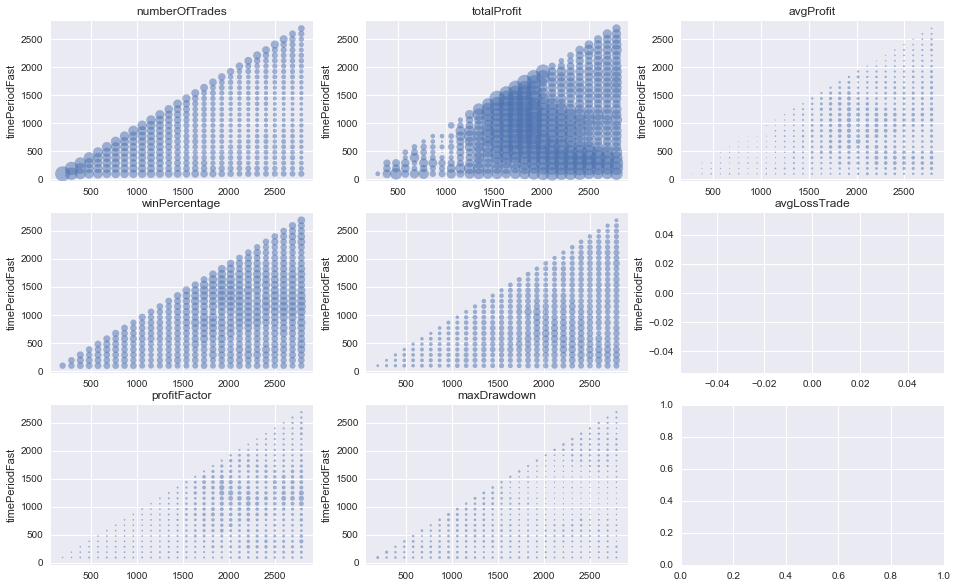

In [50]:
plotResults(allStats, 'timePeriodSlow')

In [52]:
allStats.query('totalProfit > 200').sort_values('numberOfTrades', ascending=False)

,contract,startAmount,numberOfTrades,totalProfit,avgProfit,winPercentage,avgWinTrade,avgLossTrade,profitFactor,maxDrawdown,timePeriodFast,timePeriodSlow
0,usdt,"1,000.0000",61.0000,227.0860,3.7227,57.3770,14.3419,-5.3080,3.6372,3.7407,1440,1536
0,usdt,"1,000.0000",53.0000,212.2781,4.0052,49.0566,19.1134,-5.5351,3.3252,3.1995,1728,1824
0,usdt,"1,000.0000",38.0000,230.5053,6.0659,55.2632,21.0706,-4.3955,5.9216,1.9032,1440,1632
0,usdt,"1,000.0000",34.0000,212.3933,6.2469,58.8235,20.3649,-4.2622,6.8258,1.2254,1344,1632
0,usdt,"1,000.0000",31.0000,212.4172,6.8522,61.2903,20.5284,-3.5321,9.2021,1.8694,1536,1824
0,usdt,"1,000.0000",30.0000,210.7725,7.0258,66.6667,19.3502,-4.1178,9.3983,1.4676,1536,1728
0,usdt,"1,000.0000",28.0000,227.8765,8.1384,64.2857,22.9982,-4.9130,8.4260,1.2306,1248,1632
0,usdt,"1,000.0000",28.0000,223.3456,7.9766,57.1429,25.6162,-4.1715,8.1877,1.2400,1248,1728
0,usdt,"1,000.0000",28.0000,229.3534,8.1912,67.8571,21.1933,-4.0214,11.1257,1.0375,1440,1728
0,usdt,"1,000.0000",27.0000,236.6930,8.7664,51.8519,30.5877,-4.1223,7.9908,2.0712,1152,1728


# Conclusion

Strategie Moving Average crossover, uz dokaze na paru usdt-btc, vytvorit az 25% zisk za necele dva roky. Bohuzel vytvari celkem 
malo obchodu (za dva roky kolem 50-60). Ze zkusennosti z marketu, a sledovani volatility moc dobre vime, ze lze vydelat daleko vice. Crossover moving average by vsak mohl byt dobrou featurou, pro machine learning techniky.